# 计算建模实验二


In [5]:
import numpy as np
import matplotlib.pylab as plt
import cv2 as cv
import random
from sklearn.cluster import DBSCAN
from scipy.optimize import least_squares
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

## 直线拟合

### 单条直线的拟合
#### 生成待拟合点
采用直线方程加噪声的方法生成

In [6]:
a=1
b=1
x=np.arange(0,10,1)
y_true=a*x+b
y_noise=y_true+np.random.normal(0,1,x.shape)

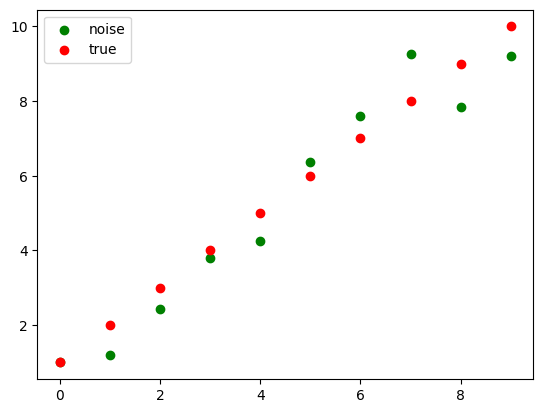

In [7]:
plt.figure()
plt.scatter(x,y_noise,label='noise',c='g')
plt.scatter(x,y_true,label='true',c='r')

plt.legend()
plt.show()


#### 最小二乘拟合

1.0161332784561212 0.7237363961992501


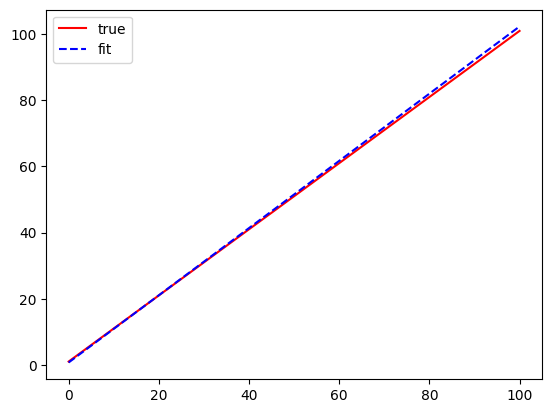

In [8]:
#最小二乘
A=np.vstack([x,np.ones(len(x))]).T
a_,b_=np.linalg.lstsq(A,y_noise,rcond=None)[0]
print(a_,b_)
plt.figure()
plt.plot([0,100],[1,101],'r-',label='true')
plt.plot([0,100],[0*a_+b_,100*a_+b_],'b--',label='fit')
plt.legend()
plt.show()





#### RANSAC拟合

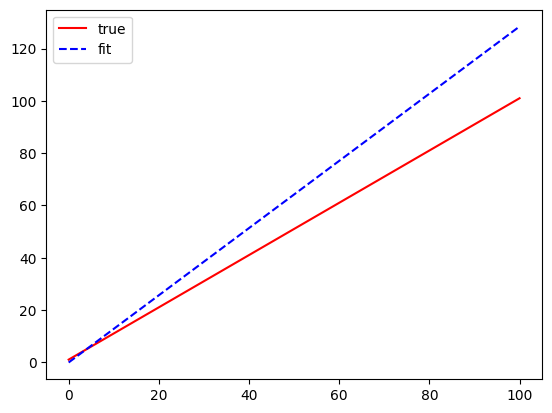

In [9]:
#RANSAC
X = x[:, np.newaxis]

ransac = RANSACRegressor(min_samples=2, residual_threshold=0.1,
                             max_trials=100, random_state=None)
ransac.fit(X, y_noise)
# 获取拟合直线的斜率和截距
a_ = ransac.estimator_.coef_[0]
b_ = ransac.estimator_.intercept_
plt.figure()
plt.plot([0,100],[1,101],'r-',label='true')
plt.plot([0,100],[0*a_+b_,100*a_+b_],'b--',label='fit')
plt.legend()
plt.show()



### 拟合多条平行直线
先进行聚类，然后对每一类进行拟合

**例** 拟合y=x+1,y=x+5,y=x+9三条直线


#### 生成添加噪声后的数据

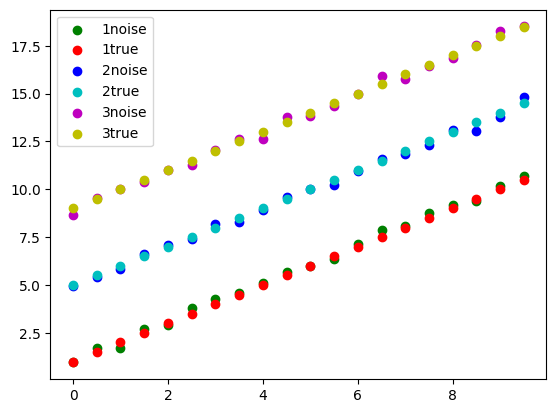

In [10]:
x=np.arange(0,10,0.5)
y1=x+1
y2=x+5
y3=x+9
X=np.concatenate((x,x,x),axis=0)
Y_true=np.concatenate((y1,y2,y3),axis=0)
Y_noise=Y_true+np.random.normal(0,0.2,Y_true.shape)
datasets_true=np.vstack((Y_true,X))
datasets_noise=np.vstack((Y_noise,X))

plt.figure()
plt.scatter(datasets_noise[1,0:20],datasets_noise[0,0:20],label='1noise',c='g')
plt.scatter(datasets_true[1,0:20],datasets_true[0,0:20],label='1true',c='r')
plt.scatter(datasets_noise[1,20:40],datasets_noise[0,20:40],label='2noise',c='b')
plt.scatter(datasets_true[1,20:40],datasets_true[0,20:40],label='2true',c='c')
plt.scatter(datasets_noise[1,40:],datasets_noise[0,40:],label='3noise',c='m')
plt.scatter(datasets_true[1,40:],datasets_true[0,40:],label='3true',c='y')

plt.legend()
plt.show()

#### 进行聚类

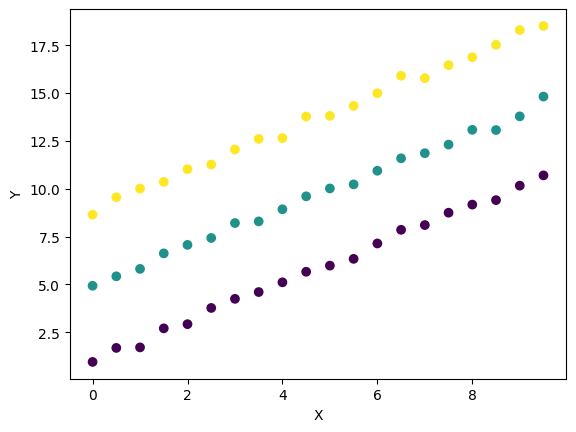

In [11]:
dbscan = DBSCAN(eps=2, min_samples=1)
labels = dbscan.fit_predict(datasets_noise.T)

# 绘制聚类结果
plt.scatter(datasets_noise.T[:, 1],datasets_noise.T[:, 0], c=labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

#### 统计类数并划分

In [12]:
n_clusters=len(set(labels))


datasets_noise_new=[]
for i in set(labels):
    dataset_noise_new=[[],[]]
    for j in range(len(datasets_noise[0])):
        if labels[j]==i:
            dataset_noise_new[0].append(datasets_noise[0,j])
            dataset_noise_new[1].append(datasets_noise[1,j])
    datasets_noise_new.append(dataset_noise_new)
    

In [13]:
def lsq(x,y):
    x=np.array(x)
    y=np.array(y)
    A=np.vstack([x,np.ones(len(x))]).T
    a_,b_=np.linalg.lstsq(A,y,rcond=None)[0]
    return a_,b_

def Ransac(x,y):
    x=np.array(x)
    y=np.array(y)
    X = x[:, np.newaxis]

    ransac = RANSACRegressor(min_samples=2, residual_threshold=0.1,
                                max_trials=100, random_state=None)
    ransac.fit(X, y)
    # 获取拟合直线的斜率和截距
    a_ = ransac.estimator_.coef_[0]
    b_ = ransac.estimator_.intercept_
    return a_,b_



#### 进行拟合

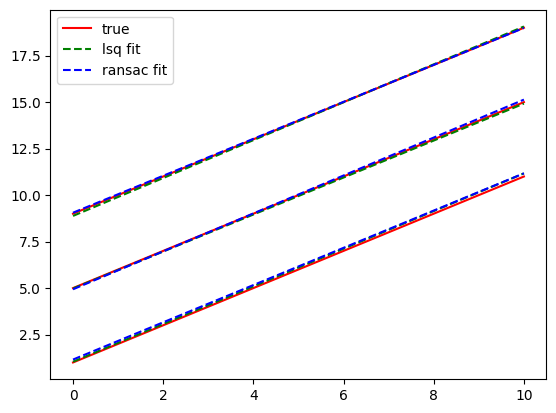

In [14]:
lsq_fit_a=[]
lsq_fit_b=[]
ransac_fit_a=[]
ransac_fit_b=[]
for i in range(len(datasets_noise_new)):
    a,b=lsq(datasets_noise_new[i][1],datasets_noise_new[i][0])
    lsq_fit_a.append(a)
    lsq_fit_b.append(b)
    a,b=Ransac(datasets_noise_new[i][1],datasets_noise_new[i][0])
    ransac_fit_a.append(a)
    ransac_fit_b.append(b)
    
plt.figure()
plt.plot([0,10],[0+1,10+1],'r-',label='true')
plt.plot([0,10],[0+5,10+5],'r-',)
plt.plot([0,10],[0+9,10+9],'r-',)
plt.plot([0,10],[lsq_fit_a[0]*0+lsq_fit_b[0],lsq_fit_a[0]*10+lsq_fit_b[0]],'g--',label='lsq fit')
plt.plot([0,10],[lsq_fit_a[1]*0+lsq_fit_b[1],lsq_fit_a[1]*10+lsq_fit_b[1]],'g--')
plt.plot([0,10],[lsq_fit_a[2]*0+lsq_fit_b[2],lsq_fit_a[2]*10+lsq_fit_b[2]],'g--')
plt.plot([0,10],[ransac_fit_a[0]*0+ransac_fit_b[0],ransac_fit_a[0]*10+ransac_fit_b[0]],'b--',label='ransac fit')
plt.plot([0,10],[ransac_fit_a[1]*0+ransac_fit_b[1],ransac_fit_a[1]*10+ransac_fit_b[1]],'b--')
plt.plot([0,10],[ransac_fit_a[2]*0+ransac_fit_b[2],ransac_fit_a[2]*10+ransac_fit_b[2]],'b--')
plt.legend()

plt.show()

## 拟合正弦函数图像
### 最小二乘法

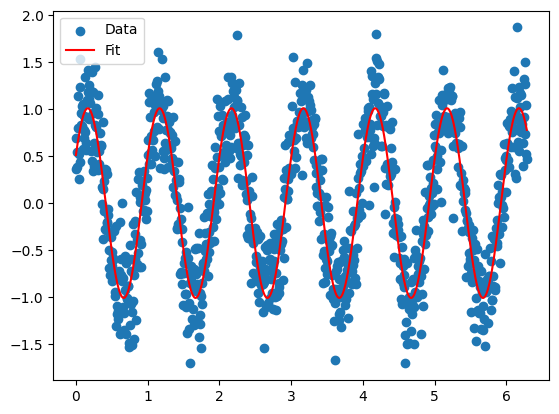

In [15]:
# 定义正弦函数
def sine_func(x, A, f, phi):
    return A * np.sin(2 * np.pi * f * x + phi)

# 生成带有噪声的数据
x = np.linspace(0, 2*np.pi, 1000)
y = 1 * np.sin(2 * np.pi * 1 * x + 0.5) + np.random.normal(0,0.3,size=x.shape)

# 初始参数的猜测值
guess_params = [1, 1, 0]

# 使用最小二乘法拟合正弦函数
params, params_covariance = curve_fit(sine_func, x, y, p0=guess_params)

# 绘制原始数据和拟合曲线
plt.scatter(x, y, label='Data')
plt.plot(x, sine_func(x, *params), color='red', label='Fit')
plt.legend()
plt.show()
